$$\frac{\text{d}u(x,t)}{\text{d}t} = F(w(x)\ast u(x,t))$$

In [20]:
import numpy as np
import pyopencl as cl
mf = cl.mem_flags

ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

nx =1000
tmax=6000

u_mat=np.zeros((tmax,nx))
u=np.random.random(nx).astype(np.float32)

u_g = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=u)
res_u_g = cl.Buffer(ctx, mf.READ_WRITE, u.nbytes)

print ctx.devices

[<pyopencl.Device 'Tesla K80' on 'NVIDIA CUDA' at 0x1e6f3a0>]


In [21]:
src = """
float w(float d)
{
  const float a=20.;
  const float b=50.;
  const float C=1.;

  return C*(exp(-d*d/(a*a))/a-exp(-d*d/(b*b))/b);
}


float F(float u)
{
  float f= 1./(1.+exp(-u-0.5));
  return f;
}


__kernel void pattern(
    __global const float *u_g,   
    __global float *res_u_g,
   int nx
)
{
  const float dt=0.1;

  int gid = get_global_id(0);
  float u =u_g[gid];

  float conv=0.;
  for(int i=0;i<nx; i++)
  {
    conv+=F(u_g[i])*w((double)abs(gid-i));
  }   
  res_u_g[gid] = u+dt*(conv);
}
"""

In [22]:
prg = cl.Program(ctx,src).build()

In [23]:
for t in xrange(tmax):
    prg.pattern(queue, (nx,), None, u_g, res_u_g, np.int32(nx))
    cl.enqueue_copy(queue, u_g, res_u_g)
    cl.enqueue_copy(queue, u, res_u_g)
    u_mat[t,:]=u

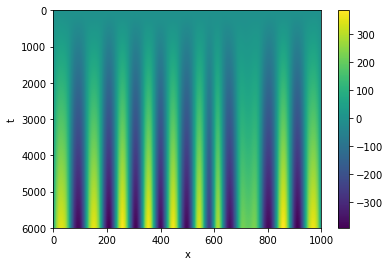

In [24]:
import pylab as pl
%matplotlib inline
pl.figure()
pl.imshow(u_mat,aspect='auto')
pl.xlabel('x')
pl.ylabel('t')
pl.colorbar()